In [4]:
import os

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.nn.functional as F
from unet import UNet
import torch
import torch.nn as nn
import torchvision
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR


In [5]:
#Dataset Creation
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

cifar10_dm = CIFAR10DataModule(
    data_dir=PATH_DATASETS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=test_transforms,
)

In [ ]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./", batch_size = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.dims = (3,32,32)
    def prepare_data(self):


In [4]:
#Loading Model
def create_model():
    model = torchvision.models.resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    model2 = UNet(in_channels=3,
             out_channels=3,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)
    return model2

In [18]:
#Lightning Model Creation
class LitResnet(LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model()

    def forward(self, x):
        out = self.model(x)
        #return F.log_softmax(out, dim=1)
        #print("OUTPUT SHAPE:", out.shape)
        return out
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        #print("LOGITS SHAPE:", logits.shape)
        #print("LOGITS SHAPE:", x.shape)
        #loss = F.nll_loss(logits, y)
        loss = F.mse_loss(x,logits)
        #loss = torch.abs(torch.mean(torch.sub(logits,x)))
        #loss = torch.sum(torch.abs((torch.sub(logits,x))))
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.mse_loss(x,logits)
        #loss = F.nll_loss(logits, y)
        #loss = torch.sum(torch.abs((torch.sub(logits,x))))
        #preds = torch.argmax(logits, dim=1)
        #acc = accuracy(preds, y, task="multiclass", num_classes=10)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            #self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        steps_per_epoch = 45000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [ ]:
#Model Training
model = LitResnet(lr=0.005)
trainer = Trainer(
    max_epochs=15,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(model, cifar10_dm)

In [ ]:
#Model Testing
trainer.test(model, datamodule=cifar10_dm)

In [ ]:
#Predict
model = LitResnet.load_from_checkpoint("logs/lightning_logs/version_8/checkpoints/esp.ckpt")
data = cifar10_dm.test_dataloader()
x = data.dataset.__getitem__(index=0)
dd =x[0]
dd = torch.unsqueeze(dd,0)
xx = model(dd)
xx = torch.squeeze(xx,0)
xx = xx.T
print(dd.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 32, 3])


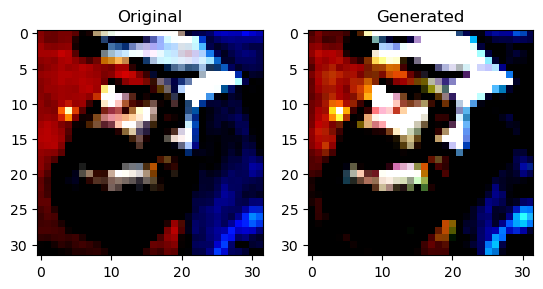

In [30]:

import matplotlib.pyplot as plt
#Original Image
print(x[0].T.shape)
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(x[0].T.detach().numpy())
#Generated Image
plt.subplot(1,2,2)
plt.title("Generated")
plt.imshow(xx.detach().numpy())